# Predicting Housing Prices - Linear Regression Model

In this project, I use a linear regression model to predict sale prices of homes. The data consists of 1460 home sales in Ames, Iowa between 2006 and 2010, and contains 81 attributes about these sales. The data was collected by Dean De Cock for the purposes of data science education. More information about the data set can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), where it is also available for download. 

In [1]:
# import packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_validate, KFold


In [2]:
# read in the data and explore

df = pd.read_csv(r'house-prices-advanced-regression-techniques/train.csv')

print(df.head())
print(df.info())

str_col_df = df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    print('\n' + col)
    print(df[col].value_counts())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Linear Regression Model

This model allows an input specifying the type of validation to perform:
* k=0 --> simple train/test split (75/25)
* k>1 --> k-fold cross-validation

In [3]:
def train_and_test(df, feature_cols, target_col, k):
    
    # k = 0 --> one train, one test
    if k == 0:
        # split into train and test
        df = df.reindex(np.random.RandomState(seed=1).permutation(df.index))
        train_df = df[:round(0.75 * len(df))]
        test_df = df[~df.index.isin(train_df)]

        # fit the model
        lr = LinearRegression()
        lr.fit(train_df[feature_cols], train_df[target_col])
        coefficients = pd.concat([pd.DataFrame(poss_feat_cols),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
        
        test_predictions = lr.predict(test_df[feature_cols])
        mse = mean_squared_error(test_df[target_col], test_predictions)
        rmse = mse ** 0.5
        
        return rmse, coefficients, test_df, test_predictions

#     # k = 1 --> simple cross validation
#     elif k == 1:
#         # split into train and test
#         df = df.reindex(np.random.RandomState(seed=1).permutation(df.index))
#         fold_one = df[:round(0.5 * len(df))]
#         fold_two = df[~df.index.isin(fold_one)]
        
#         # fit the model on fold x and test on fold y, flipping
#         rmse_list = []
#         coef_list = []
#         for train_fold, test_fold in zip([fold_one, fold_two], [fold_two, fold_one]):
#             lr = LinearRegression()
#             lr.fit(train_fold[feature_cols], train_fold[target_col])
#             coefficients = pd.concat([pd.DataFrame(poss_feat_cols),pd.DataFrame(np.transpose(lr.coef_))], axis = 1)
#             test_predictions = lr.predict(test_fold[feature_cols])
#             mse = mean_squared_error(test_fold[target_col], test_predictions)
#             rmse = mse ** 0.5
#             rmse_list.append(rmse)
#             coef_list.append(coefficients)
            
#         avg_rmse = np.mean(rmse_list)
#         coef_df = pd.concat(coef_list)
#         coef_df.columns = ['Feature', 'Coef']
        
#         return avg_rmse, coef_df
    
    # k > 1 --> k fold cross validation
    else:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        lr = LinearRegression()
        cv_results = cross_validate(lr, feat_df[feature_cols], feat_df[target_col], scoring='neg_mean_squared_error', cv=kf, return_estimator=True)
        coef_list = []
        for model in cv_results['estimator']:
            coefficients = pd.concat([pd.DataFrame(feature_cols),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
            coef_list.append(coefficients)

        avg_rmse = np.mean(abs(cv_results['test_score']) ** 0.5)
        coef_df = pd.concat(coef_list)
        coef_df.columns = ['Feature', 'Coef']
        
        return avg_rmse, coef_df



### Start cleaning the data

* Drop unecessary columns and columns with data leakage
* Convert numerical categorical columns to strings
* Create new features that may be better predictors of sale price

In [4]:
trans_df = df.copy()

# drop id column
trans_df.drop('Id', axis=1, inplace=True)

def initial_clean(trans_df):

    # convert MS SubClass into string
    trans_df['MSSubClass'] = trans_df['MSSubClass'].astype(str)

    # convert year into age
    trans_df['AgeAtSale'] = trans_df['YrSold'] - trans_df['YearBuilt']
    trans_df['YearsSinceRemodel'] = trans_df['YrSold'] - trans_df['YearRemodAdd']
    trans_df['GarageAge'] = trans_df['YrSold'] - trans_df['GarageYrBlt']
    trans_df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)

    # replace row with negative age with 0
    # neg_age_df = trans_df[(trans_df['AgeAtSale'] < 0) | (trans_df['YearsSinceRemodel'] < 0) | (trans_df['GarageAge'] < 0)]
    # print(len(neg_age_df))
#     trans_df = trans_df[(trans_df['AgeAtSale'] >= 0) & (trans_df['YearsSinceRemodel'] >= 0) & (trans_df['GarageAge'] >= 0)]
    for col in ['AgeAtSale', 'YearsSinceRemodel', 'GarageAge']:
        trans_df.loc[trans_df[col] < 0, col] = 0
    
    # add num bathrooms and total sq ft
    trans_df['NumBath'] = trans_df['BsmtFullBath'] + 0.5 * trans_df['BsmtHalfBath'] + trans_df['FullBath'] + 0.5 * trans_df['HalfBath']
    trans_df['HouseSF'] = trans_df['1stFlrSF'] + trans_df['1stFlrSF'] + trans_df['TotalBsmtSF']

    # remove columns with data leakage
    trans_df.drop(['MoSold', 'YrSold', 'SaleType', 'SaleCondition'], axis=1, inplace=True)

    return trans_df

trans_df = initial_clean(trans_df)



### Add binary "exists" columns

Add attributes showing simply whether something existed or not, rather than its quality or square footage.

In [5]:
def create_exists_feat(trans_df):

    trans_df.loc[pd.isnull(trans_df['BsmtQual']), 'BsmtExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['BsmtQual']), 'BsmtExists'] = 1

    trans_df.loc[trans_df['2ndFlrSF'] == 0, '2ndFlrExists'] = 0
    trans_df.loc[trans_df['2ndFlrSF'] > 0, '2ndFlrExists'] = 1

    trans_df.loc[trans_df['WoodDeckSF'] + trans_df['OpenPorchSF'] + trans_df['EnclosedPorch'] + trans_df['3SsnPorch'] + trans_df['ScreenPorch'] == 0, 'PorchExists'] = 0
    trans_df.loc[trans_df['WoodDeckSF'] + trans_df['OpenPorchSF'] + trans_df['EnclosedPorch'] + trans_df['3SsnPorch'] + trans_df['ScreenPorch'] > 0, 'PorchExists'] = 1

    trans_df.loc[pd.isnull(trans_df['PoolQC']), 'PoolExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['PoolQC']), 'PoolExists'] = 1

    trans_df.loc[pd.isnull(trans_df['Fence']), 'FenceExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['Fence']), 'FenceExists'] = 1

    trans_df.loc[pd.isnull(trans_df['Alley']), 'AlleyExists'] = 0
    trans_df.loc[~pd.isnull(trans_df['Alley']), 'AlleyExists'] = 1

    trans_df.loc[trans_df['MiscFeature'] == 'Shed', 'ShedExists'] = 1
    trans_df.loc[trans_df['MiscFeature'] != 'Shed', 'ShedExists'] = 0

    for col in ['BsmtExists', '2ndFlrExists', 'PorchExists', 'PoolExists', 'FenceExists', 'AlleyExists', 'ShedExists']:
        print(trans_df[col].value_counts())

    # why isn't garage included? garage always exists
    
    return trans_df

trans_df = create_exists_feat(trans_df)



1.0    1423
0.0      37
Name: BsmtExists, dtype: int64
0.0    829
1.0    631
Name: 2ndFlrExists, dtype: int64
1.0    1206
0.0     254
Name: PorchExists, dtype: int64
0.0    1453
1.0       7
Name: PoolExists, dtype: int64
0.0    1179
1.0     281
Name: FenceExists, dtype: int64
0.0    1369
1.0      91
Name: AlleyExists, dtype: int64
0.0    1411
1.0      49
Name: ShedExists, dtype: int64


### Handle missing values

* Remove rows where only a few are missing
* Remove columns where many are missing


In [6]:
def handle_missing_values(trans_df):

    null_counts = trans_df.isnull().sum()[trans_df.isnull().sum() > 0]
    print(null_counts)
    for col in null_counts.index:
        print('\n')
        print(trans_df[col].value_counts())

    # replace null veneer types with 'None'
    trans_df['MasVnrType'].fillna('None', inplace=True)
    trans_df['MasVnrArea'].fillna(0, inplace=True)

    # replace blank lot frontage with 0
    trans_df['LotFrontage'].fillna(0, inplace=True)

    # drop columns
    # few pools exist - remove pool attributes, replace with existence
    # alley, fence, fireplace have many missing results; replace with existence/number
    # misc features are most sheds or nulls; replace with shed existence
    trans_df.drop(['PoolArea', 'PoolQC', 'Alley', 'MiscFeature', 'MiscVal', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

    # 33 rows left with missing values (electricity and basement attributes) - remove these
    # and remove basement exists, since all values are now 1
    trans_df = trans_df[~trans_df.isnull().any(axis=1)]
    trans_df.drop('BsmtExists', axis=1, inplace=True)
    
    return trans_df
    
trans_df = handle_missing_values(trans_df)



LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
GarageAge         81
dtype: int64


60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
112.0      1
138.0      1
149.0      1
38.0       1
111.0      1
Name: LotFrontage, Length: 110, dtype: int64


Grvl    50
Pave    41
Name: Alley, dtype: int64


None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


0.0      861
108.0      8
72.0       8
180.0      8
16.0       7
        ... 
31.0       1
366.0      1
528.0      1
894.0      1
415.0      1
Name: MasVnrArea, Length: 327, dtype: int64


TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: i

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Map quality variables to ordinal values

Many of the columns in this dataset are qualitative (e.g. excellent vs good vs average vs poor) and can be translated to an ordinal scale.

In [7]:
def map_qual_to_ord(trans_df):

    street_dict = {'Pave': 1, 'Grvl': 0}
    trans_df['Street'] = trans_df['Street'].map(street_dict)

    util_dict = {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}
    trans_df['Utilities'] = trans_df['Utilities'].map(util_dict)

    slope_dict = {'Gtl': 0, 'Mod': -1, 'Sev': -2}
    trans_df['LandSlope'] = trans_df['LandSlope'].map(slope_dict)

    bsmtexp_dict = {'Gd': 3, 'Av': 2, 'Mn': 1, 'No': 0}
    trans_df['BsmtExposure'] = trans_df['BsmtExposure'].map(bsmtexp_dict)

    bsmtfin_dict = {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0}
    trans_df['BsmtFinType1'] = trans_df['BsmtFinType1'].map(bsmtfin_dict)
    trans_df['BsmtFinType2'] = trans_df['BsmtFinType2'].map(bsmtfin_dict)

    air_dict = {'N': 0, 'Y': 1}
    trans_df['CentralAir'] = trans_df['CentralAir'].map(air_dict)

    elec_dict = {'SBrkr': 1, 'FuseA': 0, 'Mix': 0, 'FuseF': -1, 'FuseP': -2}
    trans_df['Electrical'] = trans_df['Electrical'].map(elec_dict)

    func_dict = {'Typ': 0, 'Min1': -1, 'Min2': -2, 'Mod': -3, 'Maj1': -4, 'Maj2': -5, 'Sev': -6, 'Sal': -7}
    trans_df['Functional'] = trans_df['Functional'].map(func_dict)

    grgfin_dict = {'Fin': 2, 'RFn': 1, 'Unf': 0}
    trans_df['GarageFinish'] = trans_df['GarageFinish'].map(grgfin_dict)

    drive_dict = {'Y': 2, 'P': 1, 'N': 0}
    trans_df['PavedDrive'] = trans_df['PavedDrive'].map(drive_dict)

    qual_dict = {'Ex': 2, 'Gd': 1, 'TA': 0, 'Fa': -1, 'Po': -2}
    for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']:
        trans_df[col] = trans_df[col].map(qual_dict)
        
    return trans_df

trans_df = map_qual_to_ord(trans_df)



### Check for skew

Transform the target variable to make it more normal.

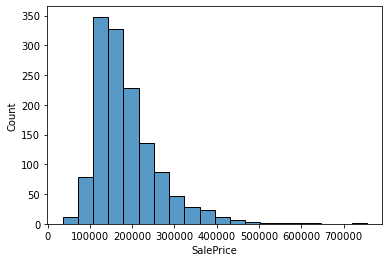

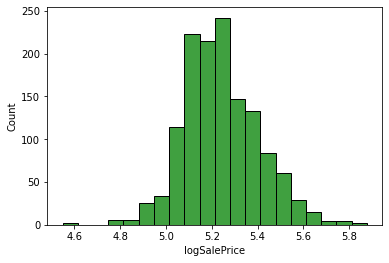

In [8]:
def log_target(trans_df):
    sns.histplot(data=trans_df, x='SalePrice', bins=20)
    plt.show()

    trans_df['logSalePrice'] = np.log10(trans_df['SalePrice'])

    sns.histplot(data=trans_df, x='logSalePrice', bins=20, color='green')
    plt.show()
    
    return trans_df

trans_df = log_target(trans_df)



### Initial categorical feature selection

* Remove low-variance categorical variables - those where at least 90% of the values are the same
* DON'T remove categorical variables with large number of categories; there aren't many and they seem to correlate with the target variable
* Dummy up remaining categorical variables into binary columns



Large number of categories:


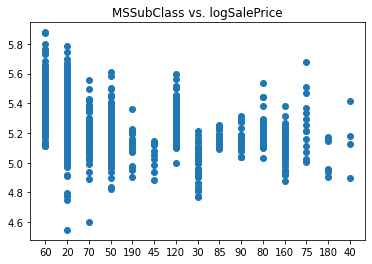

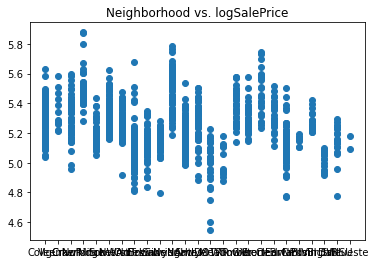

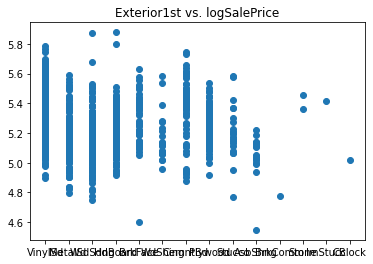

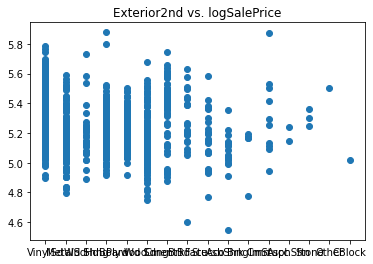


Dropped because too little variance:
   LandContour
Lvl    1214
Bnk      52
HLS      48
Low      32
Name: LandContour, dtype: int64
   Condition2
Norm      1332
Feedr        5
RRNn         2
Artery       2
PosN         2
RRAe         1
PosA         1
RRAn         1
Name: Condition2, dtype: int64
   RoofMatl
CompShg    1322
Tar&Grv       9
WdShngl       6
WdShake       5
Metal         1
ClyTile       1
Membran       1
Roll          1
Name: RoofMatl, dtype: int64
   Heating
GasA    1326
GasW      16
Grav       3
OthW       1
Name: Heating, dtype: int64

Dropped because too little variance:


In [9]:
feat_df = trans_df.copy()

def str_to_cat(feat_df):
    
    # convert category columns to type category
    cat_col_list = []
    str_col_df = feat_df.copy().select_dtypes(include=['object'])
    for col in str_col_df.columns:
        feat_df[col] = feat_df[col].astype('category')
        cat_col_list.append(col)

    # create dummy columns and add back to the df
    feat_df = pd.concat([feat_df, pd.get_dummies(feat_df.select_dtypes(include=['category']))], axis=1).drop(cat_col_list,axis=1)

    return feat_df

    
print('\nLarge number of categories:')
str_col_df = feat_df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    if str_col_df[col].nunique() >= 10:
        plt.scatter(feat_df[col], feat_df['logSalePrice'])
        plt.title(col + ' vs. logSalePrice')
        plt.show()
#         feat_df.drop(col, axis=1, inplace=True)

# exclude columns with low variance - where more than 90% of values are the same
print('\nDropped because too little variance:')
str_col_df = feat_df.copy().select_dtypes(include=['object'])
for col in str_col_df.columns:
    if str_col_df[col].value_counts().max()/str_col_df[col].value_counts().sum() >= 0.9:
        print('   ' + col)
        print(feat_df[col].value_counts())
        feat_df.drop(col, axis=1, inplace=True)

# # convert category columns to type category
# cat_col_list = []
# str_col_df = feat_df.copy().select_dtypes(include=['object'])
# for col in str_col_df.columns:
#     feat_df[col] = feat_df[col].astype('category')
#     cat_col_list.append(col)
    
# # create dummy columns and add back to the df
# feat_df = pd.concat([feat_df, pd.get_dummies(feat_df.select_dtypes(include=['category']))], axis=1).drop(cat_col_list,axis=1)

feat_df = str_to_cat(feat_df)

# exclude columns with low variance again - this time including the dummies - where more than 90% of values are the same
print('\nDropped because too little variance:')
for col in feat_df.columns:
    if feat_df[col].value_counts().max()/feat_df[col].value_counts().sum() >= 0.9:
        feat_df.drop(col, axis=1, inplace=True)


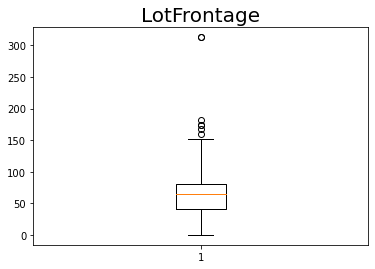

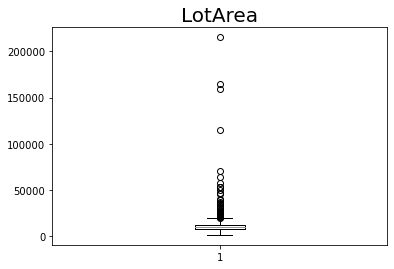

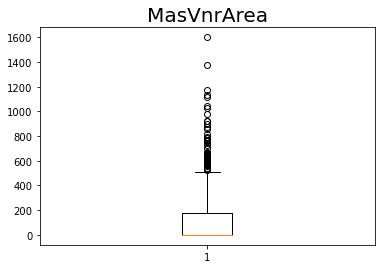

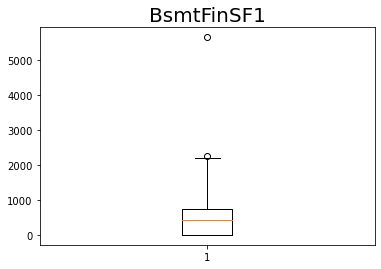

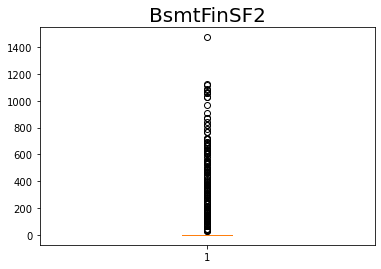

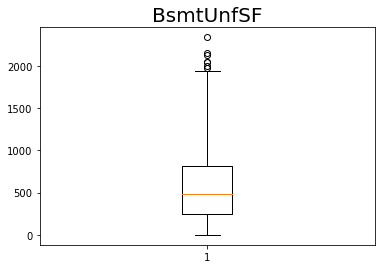

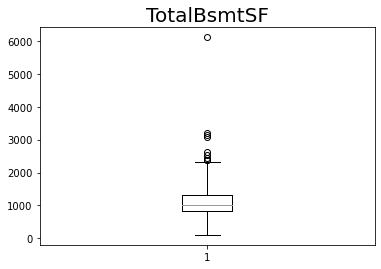

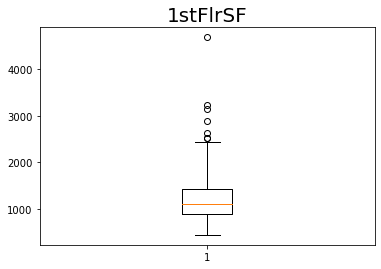

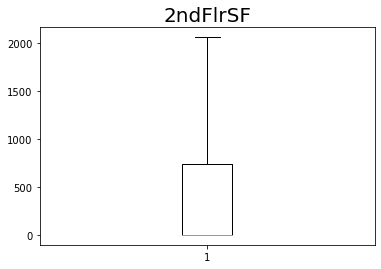

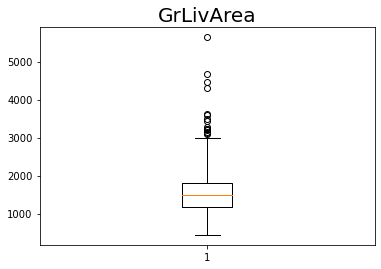

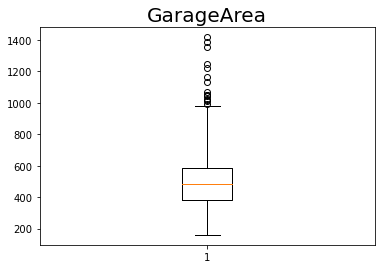

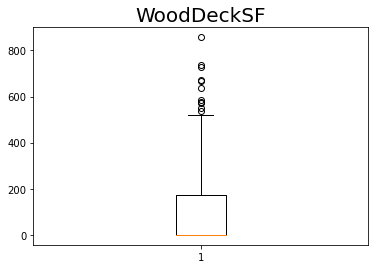

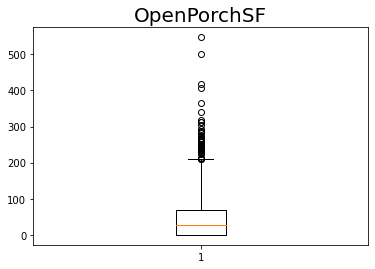

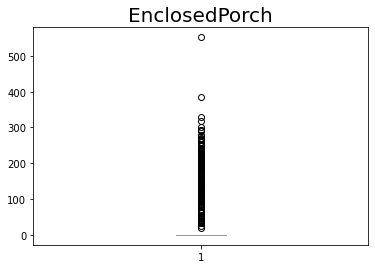

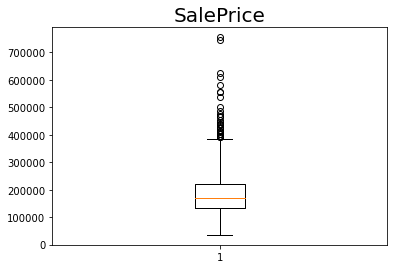

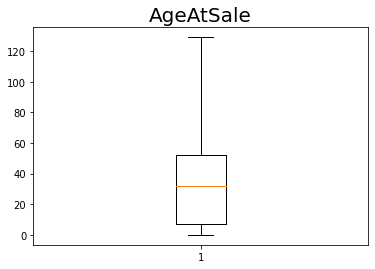

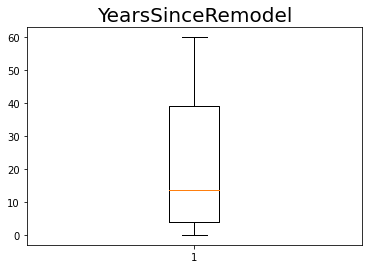

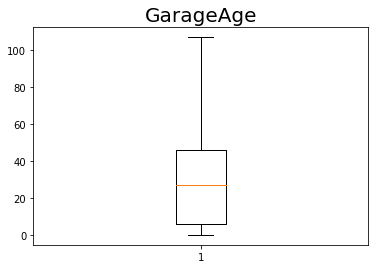

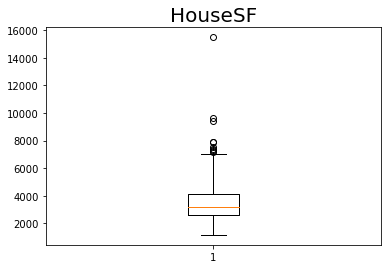

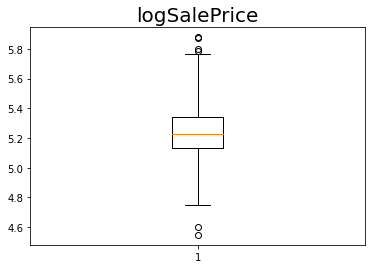


Outliers to remove: 16


In [10]:
# plot each feature to check for outliers and remove

num_col_df = feat_df.copy().select_dtypes(include=['int', 'float'])
for col in feat_df.columns:
    if feat_df[col].nunique() > 10:
        plt.boxplot(feat_df[col], whis=2)
        plt.title(col, fontsize=20)
        plt.show()

outlier_df = feat_df[(feat_df['LotFrontage'] == feat_df['LotFrontage'].max())
                    | (feat_df['LotArea'].isin(feat_df.nlargest(4, 'LotArea')['LotArea']))
                    | (feat_df['MasVnrArea'].isin(feat_df.nlargest(2, 'MasVnrArea')['MasVnrArea']))
                    | (feat_df['BsmtFinSF1'] == feat_df['BsmtFinSF1'].max())
                    | (feat_df['BsmtFinSF2'] == feat_df['BsmtFinSF2'].max())
                    | (feat_df['TotalBsmtSF'] == feat_df['TotalBsmtSF'].max())
                    | (feat_df['1stFlrSF'] == feat_df['1stFlrSF'].max())
                    | (feat_df['GrLivArea'].isin(feat_df.nlargest(3, 'GrLivArea')['GrLivArea']))
                    | (feat_df['WoodDeckSF'] == feat_df['WoodDeckSF'].max())
                    | (feat_df['OpenPorchSF'].isin(feat_df.nlargest(2, 'OpenPorchSF')['OpenPorchSF']))
                    | (feat_df['EnclosedPorch'] == feat_df['EnclosedPorch'].max())
                    | (feat_df['HouseSF'] == feat_df['HouseSF'].max())
                    | (feat_df['SalePrice'].isin(feat_df.nlargest(2, 'SalePrice')['SalePrice']))
                    ]

print('\nOutliers to remove: ' + str(len(outlier_df)))
feat_df = feat_df[~feat_df.index.isin(outlier_df.index)]
   
        

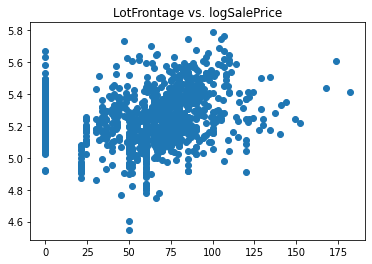

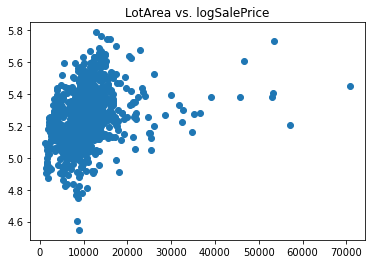

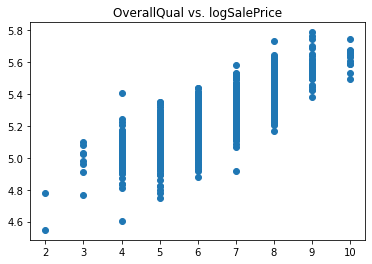

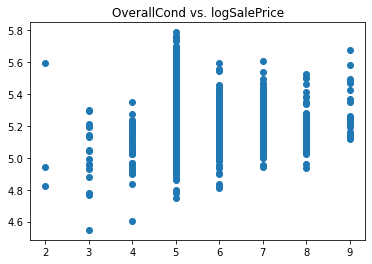

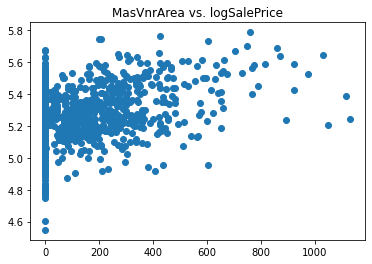

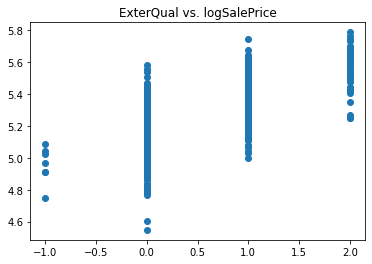

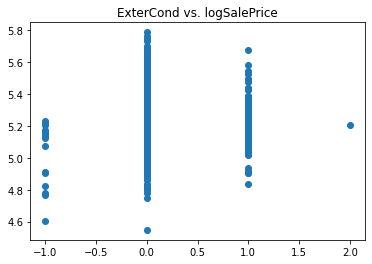

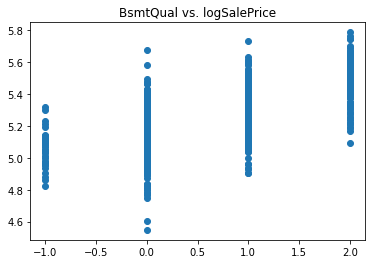

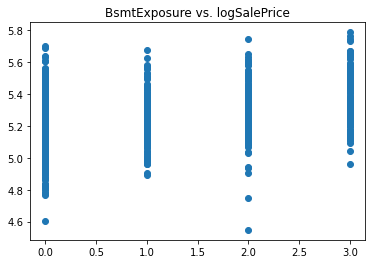

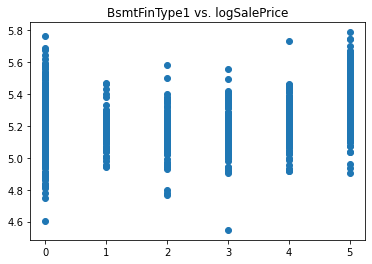

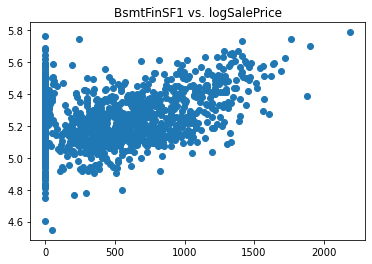

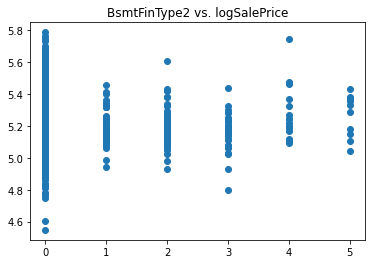

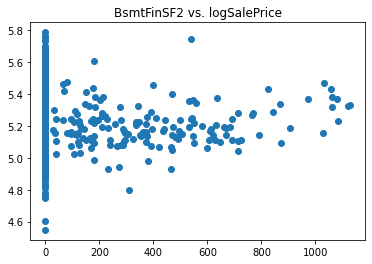

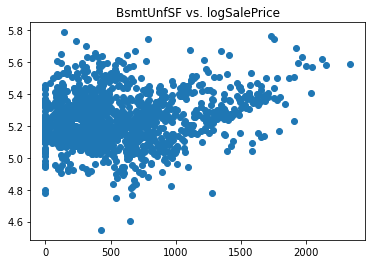

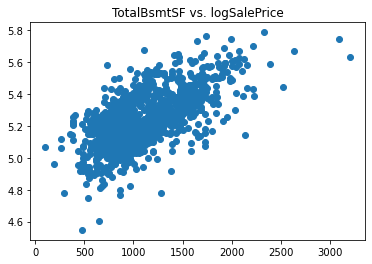

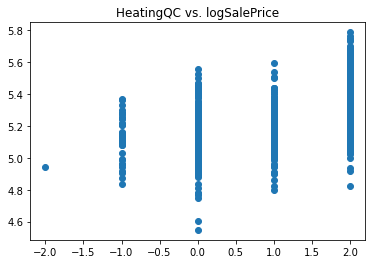

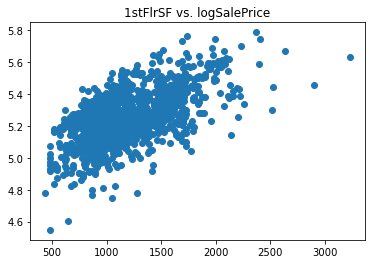

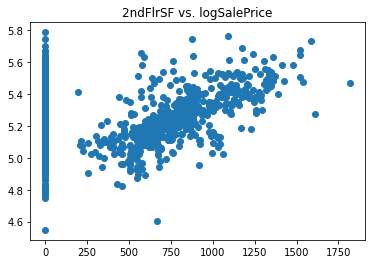

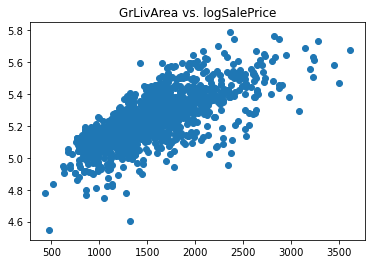

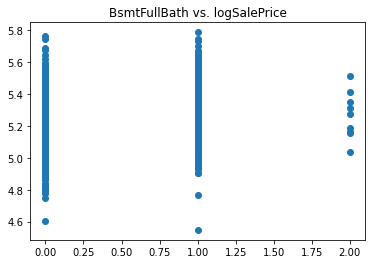

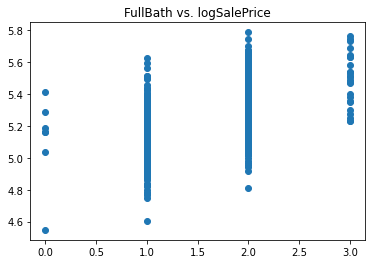

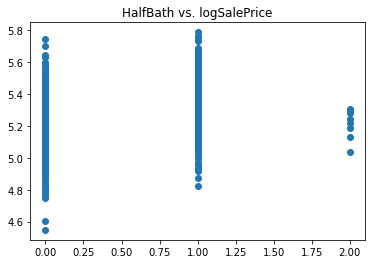

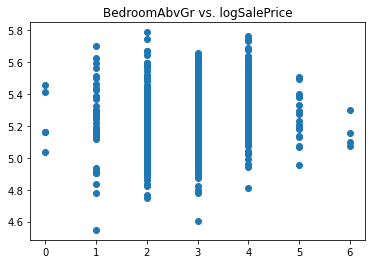

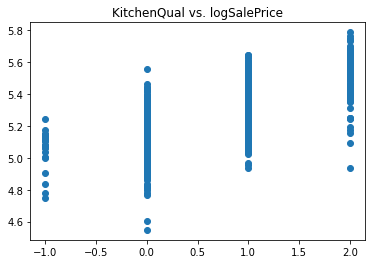

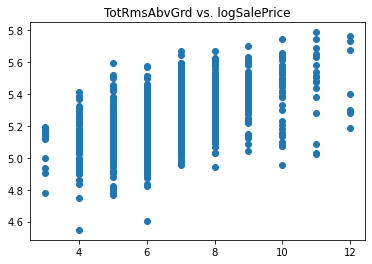

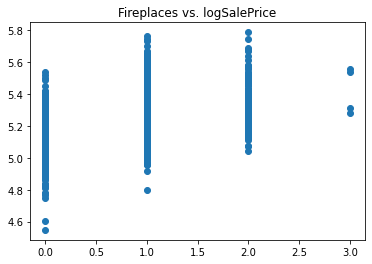

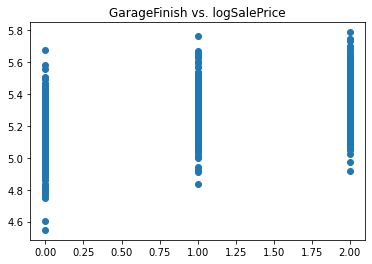

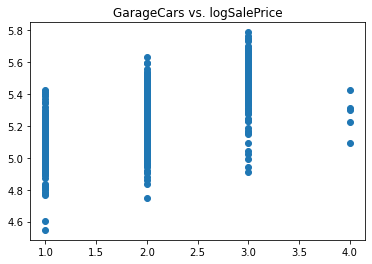

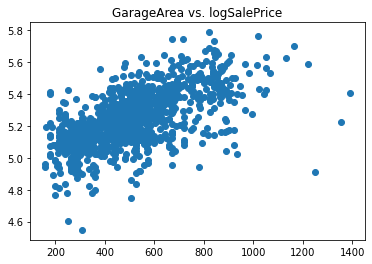

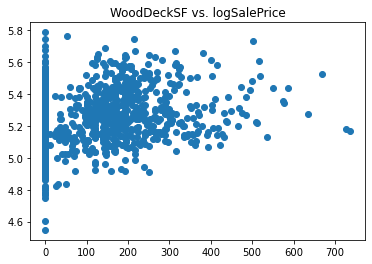

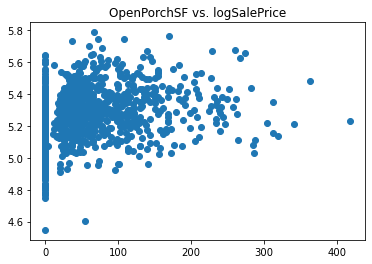

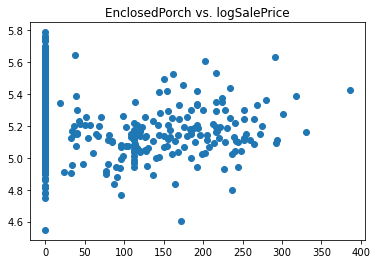

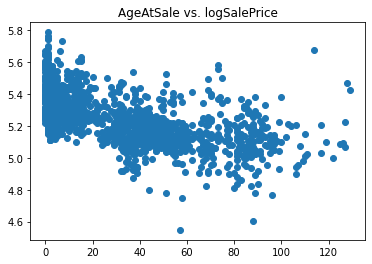

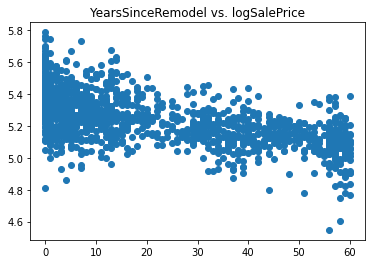

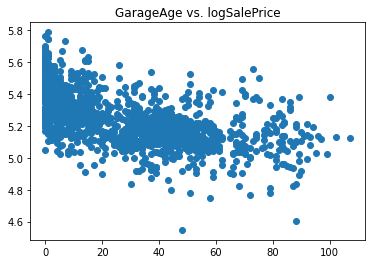

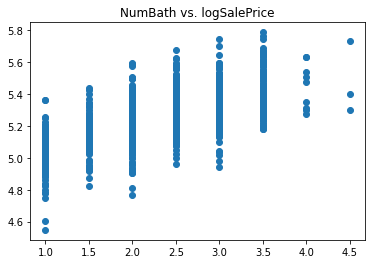

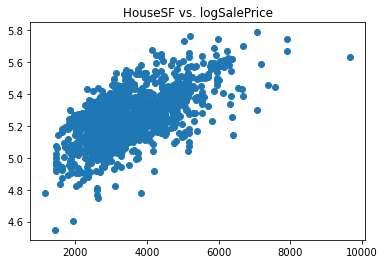

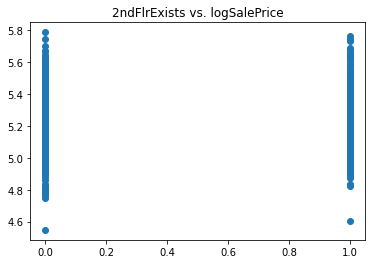

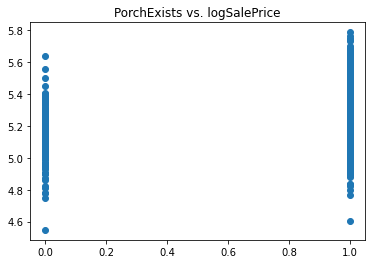

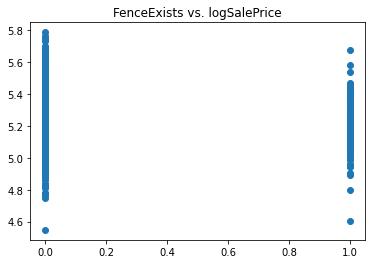

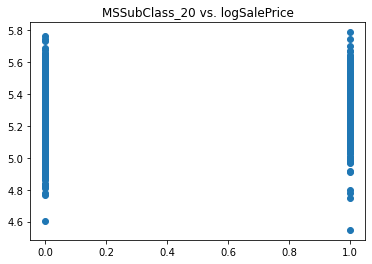

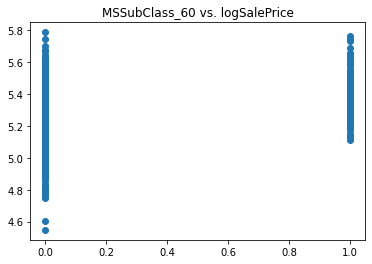

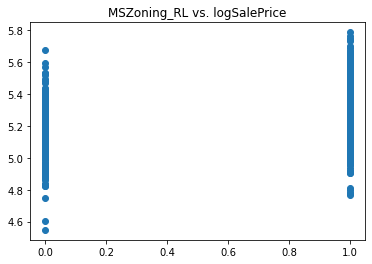

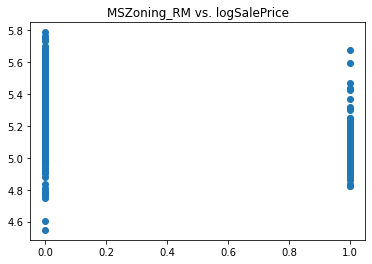

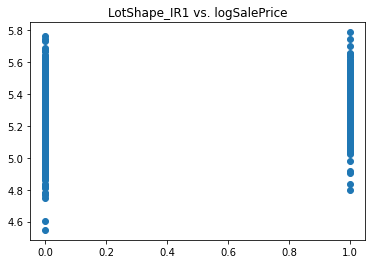

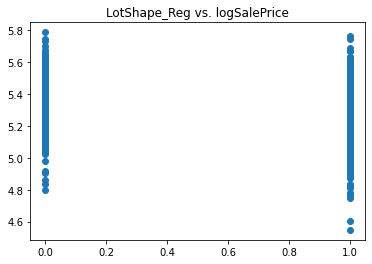

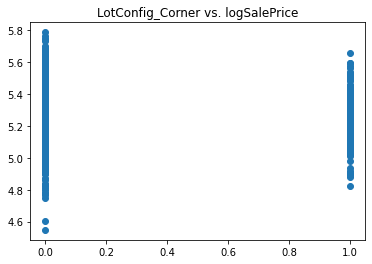

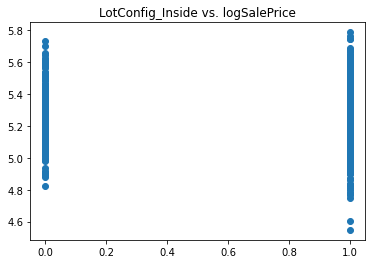

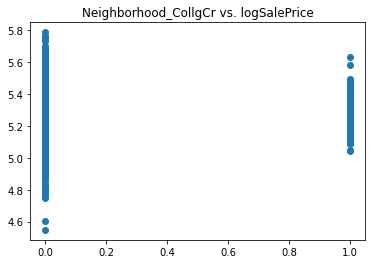

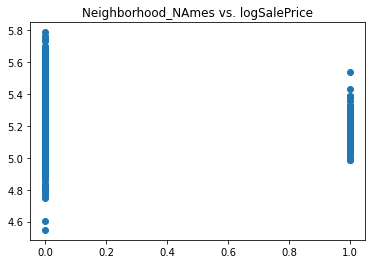

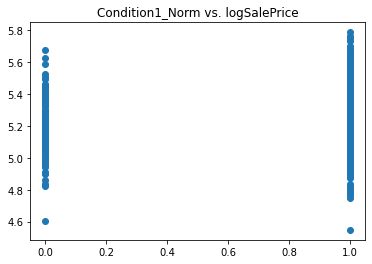

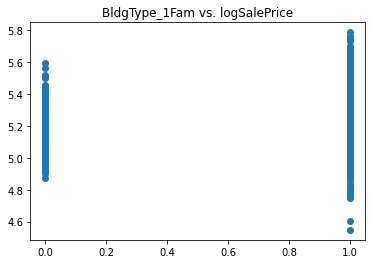

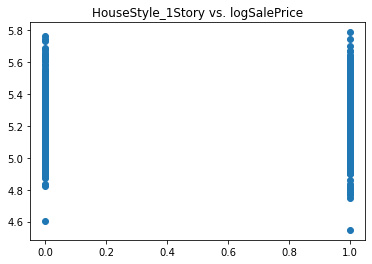

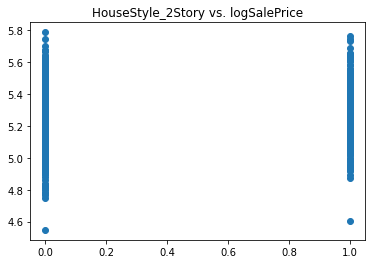

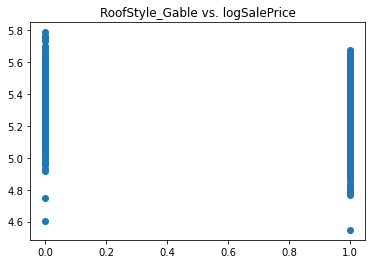

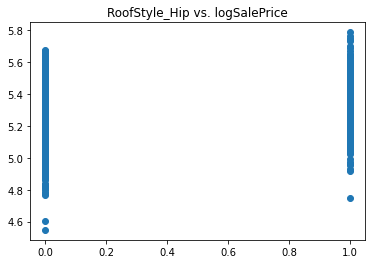

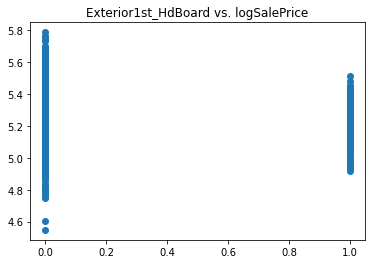

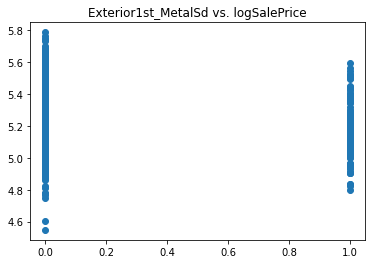

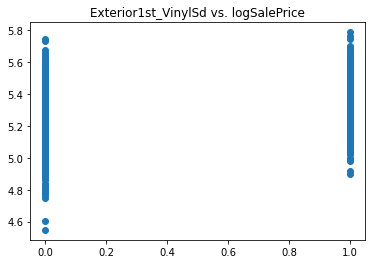

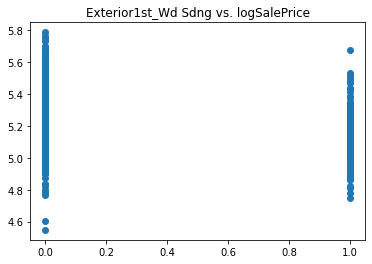

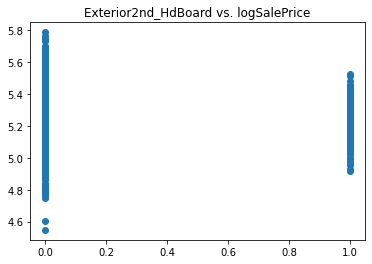

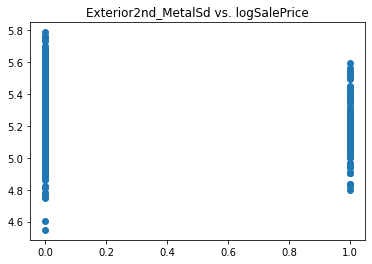

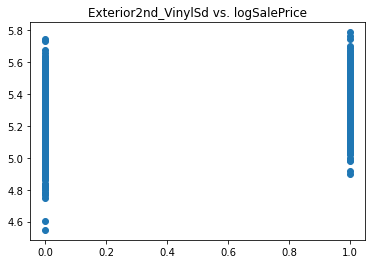

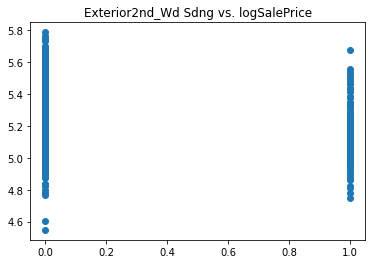

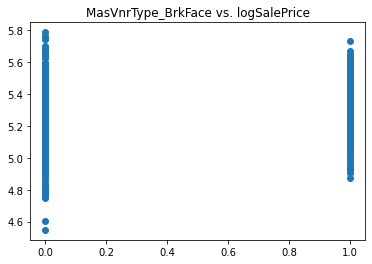

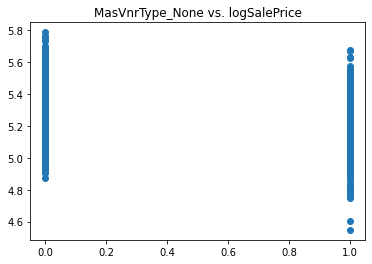

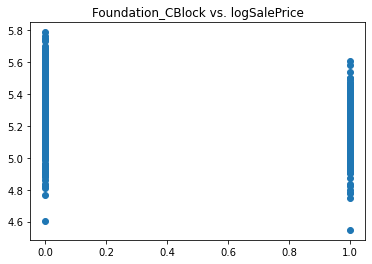

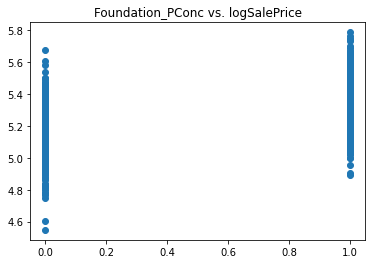

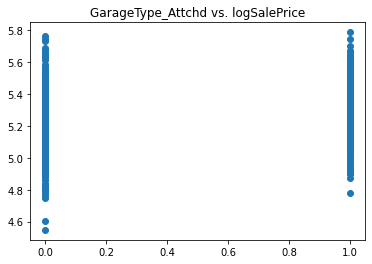

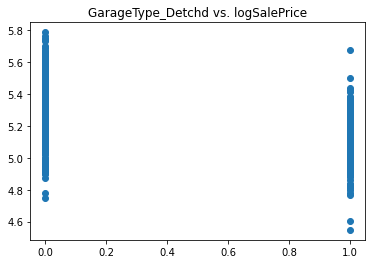

In [11]:
# plot each feature var against the log sale price
for col in feat_df:
    if col not in ['SalePrice', 'logSalePrice']:
        plt.scatter(feat_df[col], feat_df['logSalePrice'])
        plt.title(col + ' vs. logSalePrice')
        plt.show()
         
            

### Low variance

Should we remove numerical features with low variance? Many features are expected to have low variance due to dummied categorical variables and the nature of the variables (e.g. a house is likely to have 1 - 2 kitchens). Let's not for now.


### Collinearity

* Check columns with suspected collinearity
* Check for collinearity of 0.8 or more. Keep the variable in the pair that is more strongly correlated with the target variable on average.


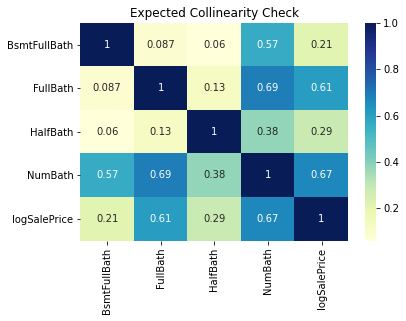

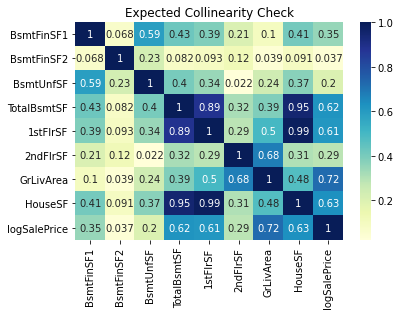

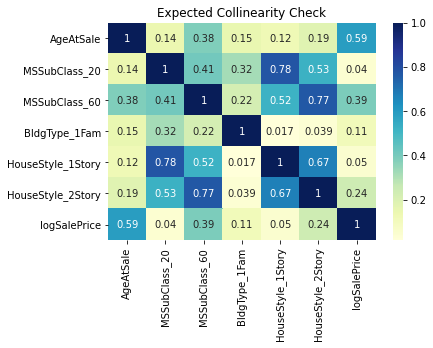

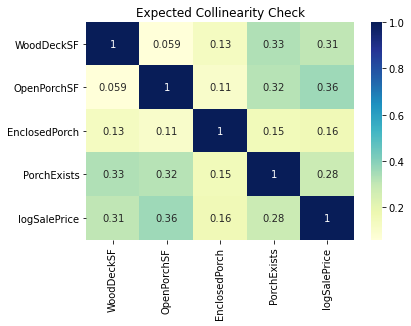

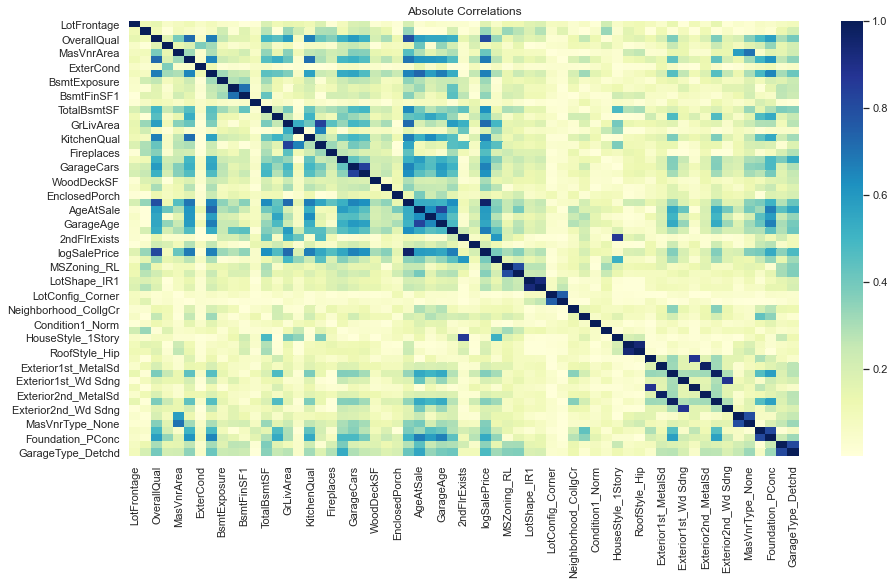

GrLivArea : TotRmsAbvGrd (0.84)
GarageCars : GarageArea (0.84)
AgeAtSale : GarageAge (0.83)
MSZoning_RL : MSZoning_RM (0.8)
LotShape_IR1 : LotShape_Reg (0.93)
2ndFlrExists : HouseStyle_1Story (0.87)
RoofStyle_Gable : RoofStyle_Hip (0.94)
Exterior1st_HdBoard : Exterior2nd_HdBoard (0.88)
Exterior1st_MetalSd : Exterior2nd_MetalSd (0.98)
Exterior1st_VinylSd : Exterior2nd_VinylSd (0.98)
Exterior1st_Wd Sdng : Exterior2nd_Wd Sdng (0.88)
Foundation_CBlock : Foundation_PConc (0.81)
GarageType_Attchd : GarageType_Detchd (0.82)


In [12]:
# handle collinearity
def check_expected_collin(feat_df, sus_cols):
    sus_cols.append('logSalePrice')
    suspect_collin_df = feat_df[sus_cols]
    sus_corrmat = suspect_collin_df.corr().abs()
    
    p = sns.heatmap(sus_corrmat, cmap='YlGnBu', annot=True)
    p.set_title('Expected Collinearity Check')
    plt.show()

check_expected_collin(feat_df, [col for col in feat_df.columns if 'BATH' in col.upper()])
check_expected_collin(feat_df, ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'HouseSF'])
check_expected_collin(feat_df, [col for col in feat_df.columns if ('MSSubClass' in col or 'BldgType' in col or 'HouseStyle' in col or col == 'AgeAtSale')])
check_expected_collin(feat_df, [col for col in feat_df.columns if ('Porch' in col or col == 'WoodDeckSF')])

# num bath is highly correlated with all other bathroom attributes and is more correlated with sale price - remove others
to_drop = [col for col in feat_df.columns if 'BATH' in col.upper() and col != 'NumBath']
feat_df.drop(to_drop, axis=1, inplace=True)

# collinearity wrt sf - house vs 1st and bsmt, 1st vs bsmt, grlivarea vs 1st and 2nd and house, basementunfin vs most
# keep grlivarea and basement attributes except unf, due to lack of collinearity and high correlation with target variable
to_drop = ['BsmtUnfSF', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'HouseSF']
feat_df.drop(to_drop, axis=1, inplace=True)

# collinearity wrt ms sub class - drop mssubclass20 and housestyle2story due to high collinearity and low correlation with target variable
to_drop = ['MSSubClass_20', 'HouseStyle_2Story']
feat_df.drop(to_drop, axis=1, inplace=True)

# collinearity wrt porch - porch exists is redundant and not as good a predictor as the others
feat_df.drop('PorchExists', axis=1, inplace=True)

# handle all cols collinearity
corrmat = feat_df.corr()
abs_corrmat = feat_df.corr().abs()
upper = abs_corrmat.where(np.triu(np.ones(abs_corrmat.shape), k=1).astype(bool))

# plot absolute correlations
sns.set(rc = {'figure.figsize':(15,8)})
p = sns.heatmap(abs_corrmat, cmap='YlGnBu')#, annot=True)
p.set_title('Absolute Correlations')
plt.show()

# for feature pairs with collinearity > 0.8, keep the one more highly correlated with the target variable
to_drop = []
for col in upper.columns:
    if col not in ['SalePrice', 'logSalePrice']:
        collin_df = upper[upper[col] > 0.8]
        for idx in collin_df.index:
            print('{f1} : {f2} ({c})'.format(f1=idx, f2=col, c=round(collin_df.loc[idx, col], 2)))
            if abs_corrmat.loc[idx, 'logSalePrice'] < abs_corrmat.loc[col, 'logSalePrice']:
                to_drop.append(idx)
            else:
                to_drop.append(col)
                
feat_df.drop(to_drop, axis=1, inplace=True)



### High correlation with the target variable

Get the correlation coefficients for the target variables and the features on different subsets of data. Keep only those that acheived 0.3 or higher at least once.


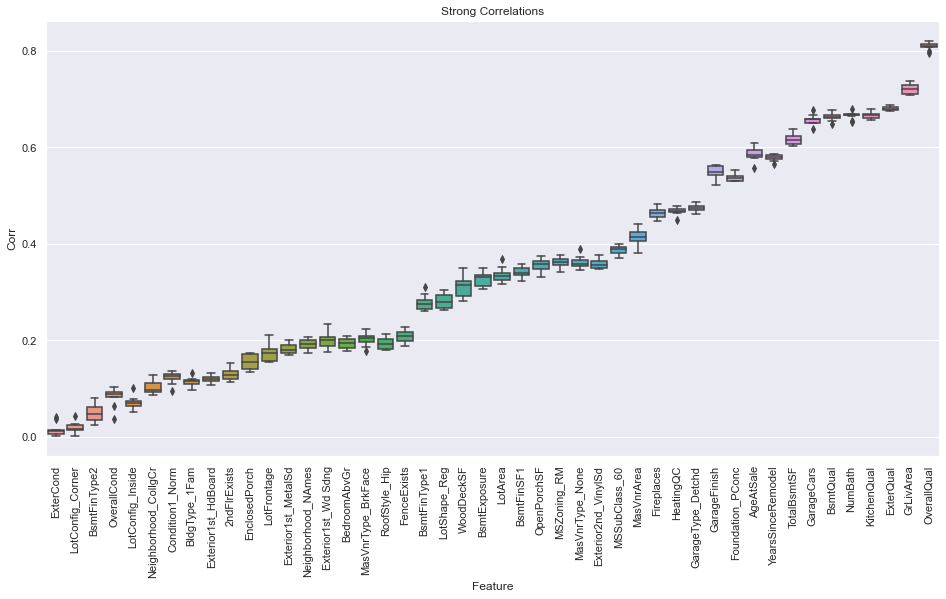

In [13]:
# get the variables most correlated with the target variable
target_var = 'logSalePrice'

# run 10 times on different subsets of the data to find the most reliably correlated
corr_df_list = []
for i in range(1, 11):

    # split into train and test data
    feature_df = feat_df.drop(target_var, axis=1) 
    target_df = feat_df[target_var]
    feat_train, feat_test, target_train, target_test = train_test_split(feature_df, target_df, test_size=0.25, random_state=i)
    train_df = feat_train.merge(target_train.to_frame(), left_index=True, right_index=True)

    # keep only the features that are highly correlated with the target variable
    sorted_corrs = train_df.corr()[target_var].abs().sort_values()
    sorted_corrs = sorted_corrs[sorted_corrs.index != target_var].reset_index()
    corr_df_list.append(sorted_corrs)
    
corr_df = pd.concat(corr_df_list)
corr_df.rename(columns={'index': 'Feature', target_var: 'Corr'}, inplace=True)

# get the average correlation with the target variable
corr_groupby = corr_df.groupby('Feature').agg(['mean', 'max', 'min'])
corr_groupby.columns = [' '.join(col).strip() for col in corr_groupby.columns.values]
corr_groupby.reset_index(inplace=True)
corr_df = pd.merge(corr_df, corr_groupby, how='left', on='Feature')

# plot correlations of the stronger (or all) features
strong_corr_df = corr_df[corr_df['Corr max'] > 0.0].sort_values('Corr')
strong_corr_df = strong_corr_df[~strong_corr_df['Feature'].isin(['SalePrice', 'logSalePrice'])]

# plt.rcdefaults()
sns.set(rc = {'figure.figsize':(16, 8)})
ax = sns.boxplot(x='Feature', y='Corr', data=strong_corr_df)
ax.set_title('Strong Correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

# remove the weakly correlated features (or none)
strong_corr_df = corr_df[corr_df['Corr min'] > 0.0]
feat_cols = list(strong_corr_df['Feature'].drop_duplicates())
feat_cols.append(target_var)
feat_df = feat_df[feat_cols]

    

## Train and test

Initial attempt at the model, erring on the side of overfitting. Test the data using different combinations of columns, starting with the most strongly correlated with the target variable and adding on.

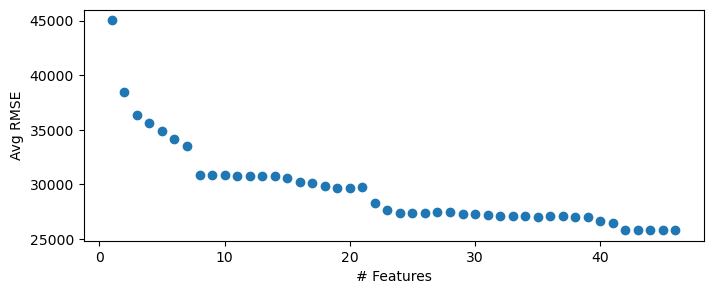

RMSE
25814.383248889455


In [14]:
# get the rmse for combinations of columns, starting with the most strongly correlated on average with the target variable

poss_feat_cols = [col for col in strong_corr_df.sort_values(by='Corr mean', ascending=False)['Feature'].unique() if col != 'SalePrice' and col in feat_df.columns]

rmse_dict = {}
for i in range(1, len(poss_feat_cols) + 1):
    rmse = train_and_test(feat_df, poss_feat_cols[:i], 'SalePrice', 10)[0]
    rmse_dict[i] = rmse
    
plt.rcdefaults()
plt.figure(figsize=(8, 3))
plt.scatter(rmse_dict.keys(), rmse_dict.values())
plt.xlabel('# Features')
plt.ylabel('Avg RMSE')
plt.show()

rmse, coef = train_and_test(feat_df, poss_feat_cols, 'SalePrice', 10)
print('RMSE')
print(rmse)



The error levels off after 42 features. Let's use the 42 most correlated with the target variable - this will provide a good estimate, and fewer features lowers the risk of overfitting.

In [16]:
best_feat_cols = poss_feat_cols[:42]
rmse, coef = train_and_test(feat_df, best_feat_cols, 'SalePrice', 10)
print('RMSE')
print(rmse)

pd.set_option('display.max_rows', 100)
print(corr_groupby[corr_groupby['Feature'].isin(best_feat_cols)].sort_values('Corr mean', ascending=False))



RMSE
25797.04393783912
                 Feature  Corr mean  Corr max  Corr min
41           OverallQual   0.809569  0.821310  0.794691
23             GrLivArea   0.720790  0.737443  0.708529
12             ExterQual   0.680824  0.688393  0.674992
38               NumBath   0.666250  0.680468  0.652198
25           KitchenQual   0.666022  0.679347  0.655762
8               BsmtQual   0.663260  0.677076  0.648633
20            GarageCars   0.656891  0.676409  0.638125
44           TotalBsmtSF   0.617138  0.637515  0.601917
1              AgeAtSale   0.585638  0.608157  0.558034
46     YearsSinceRemodel   0.578622  0.585868  0.564469
21          GarageFinish   0.548633  0.563917  0.522645
19      Foundation_PConc   0.537337  0.553337  0.529269
22     GarageType_Detchd   0.474142  0.485796  0.462727
24             HeatingQC   0.467996  0.478243  0.449633
18            Fireplaces   0.463453  0.483589  0.447306
33            MasVnrArea   0.414190  0.440305  0.381309
31         MSSubClass_60 

### Failed exploration: Feature importance

Get the feature importance from the model and remove those with weighted around 0.


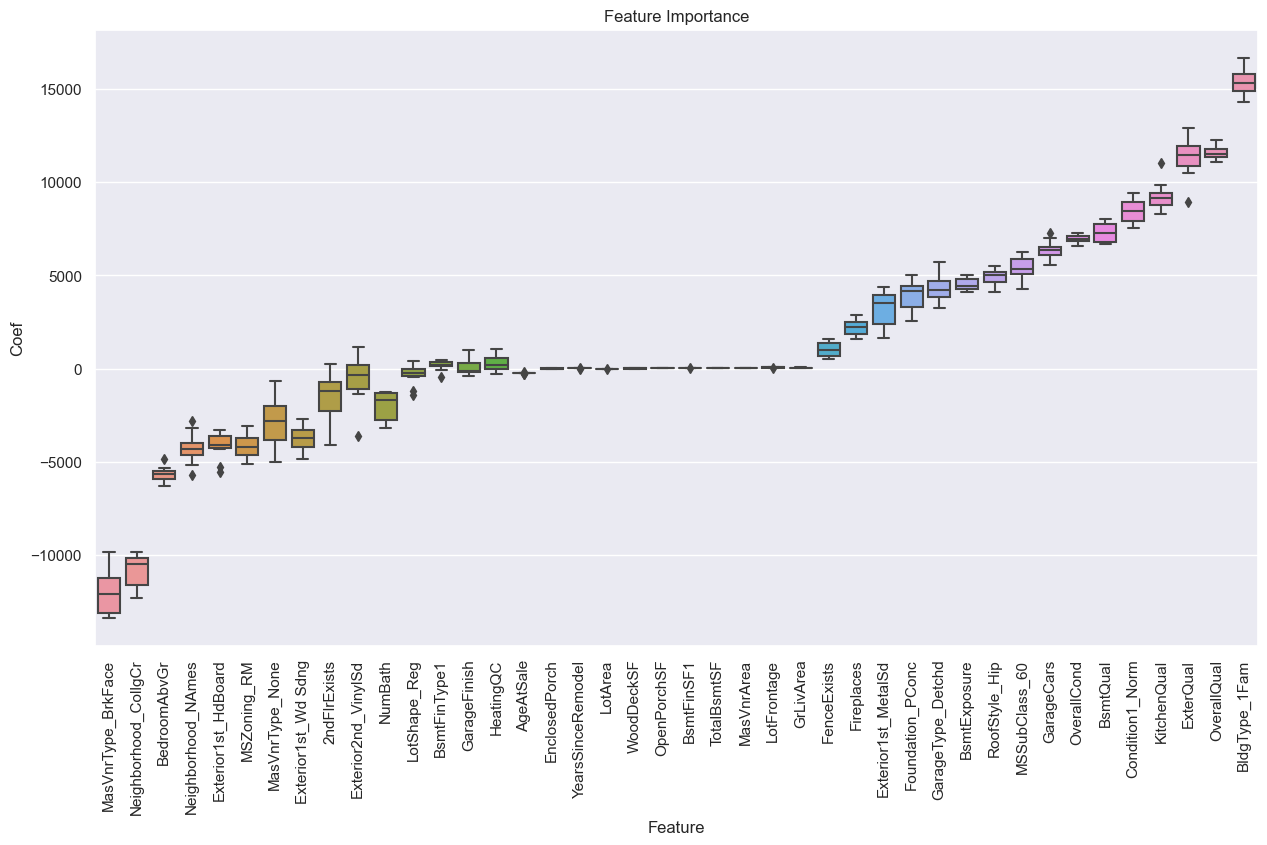

Features to drop
['BsmtFinSF1', 'EnclosedPorch', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', 'WoodDeckSF', 'YearsSinceRemodel']
RMSE
33072.73274057823


In [17]:
# plot coefficients if k-fold cv
if isinstance(coef, pd.DataFrame):
    sns.set(rc = {'figure.figsize':(15,8)})
    ax = sns.boxplot(x='Feature', y='Coef', data=coef.sort_values(by='Coef'))
    ax.set_title('Feature Importance')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.show()
    
    coef_groupby = coef.groupby('Feature').agg(['mean', 'max', 'min'])
    coef_groupby.columns = [' '.join(col).strip() for col in coef_groupby.columns.values]
    coef_groupby.reset_index(inplace=True)
    
else:
    print(coef)

# drop features that have little importance on the outcome and rerun the model
to_drop = list(coef_groupby[(coef_groupby['Coef min'] >= -100) & (coef_groupby['Coef max'] <= 100)]['Feature'])
new_poss_feat_cols = [col for col in poss_feat_cols if col not in to_drop]
print('Features to drop')
print(to_drop)

rmse, coef = train_and_test(feat_df, new_poss_feat_cols, 'SalePrice', 10)
print('RMSE')
print(rmse)

    

This *increases* the RMSE by about 30%. Let's not do that!!

### Failed exploration: Train and test using manually chosen features

Just use the manually chosen fields that seem useful.


In [18]:
man_chosen_feat_cols = ['OverallQual', 'GrLivArea', 'BedroomAbvGr', '2ndFlrExists', 'LotArea', 'GarageCars', 'Fireplaces', 'BsmtQual']

rmse = train_and_test(feat_df, man_chosen_feat_cols, 'SalePrice', 10)[0]
print(rmse)


31633.05078770956


This increases the RMSE by about 30%. Lesson learned: I do not know better than a machine.

### Plot the error

Using the best model we have, compare the predictions on the test set with the actual values.

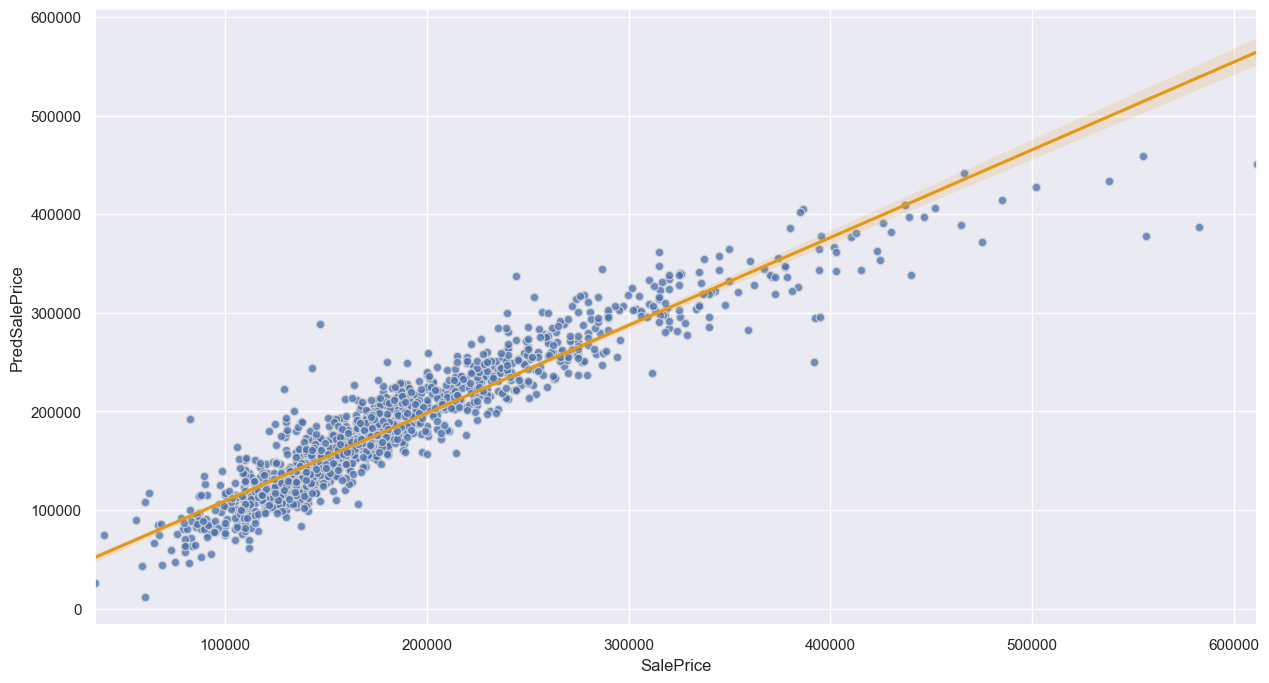

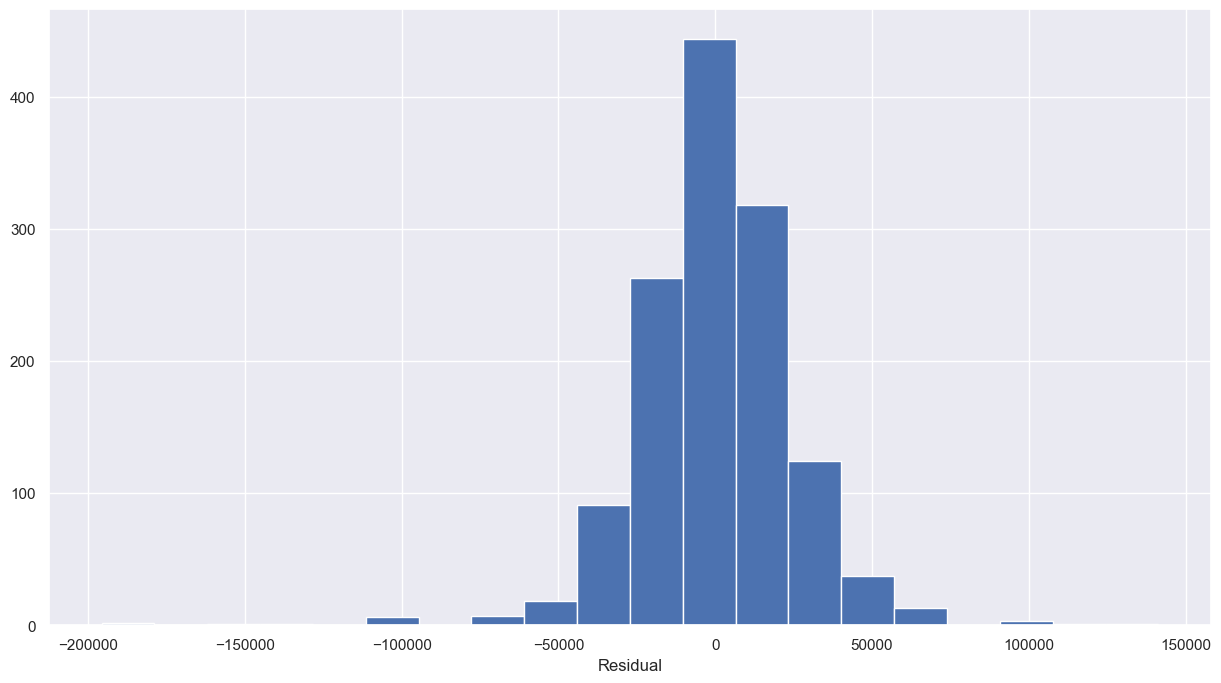

In [19]:
rmse, coefficients, test_df, test_predictions = train_and_test(feat_df, best_feat_cols, 'SalePrice', 0)
test_df['PredSalePrice'] = test_predictions

sns.set_theme()
sns.regplot(x='SalePrice', y='PredSalePrice', data=test_df, scatter_kws={'edgecolors': 'lightgray'}, line_kws={'color': '#e49817'})
plt.show()

plt.hist(test_predictions - test_df['SalePrice'], bins=20)
plt.xlabel('Residual')
plt.show()



## Conclusions

The linear regression model using the features below yielded an RMSE of $25,797 — 14\% of the mean sale price — under 10-fold cross validation.

|Feature | Definition|
|:---|:---|
|OverallQual | Overall quality of the house (1 = very poor, 10 = very excellent)|
|OverallCond | Overall condition of the house (1 = very poor, 10 = very excellent)|
|AgeAtSale | Number of years since the house was built|
|YearsSinceRemodel | Number of years since the house was remodeled|
|MSSubClass_60 | Binary indicating that the house is a 2-story built after 1946|
|BldgType_1Fam | Binary indicating that the house is a single family detached home|
|2ndFlrExists | Binary indicating whether a second floor exists|
|GrLivArea | Square feet of living space above ground level|
|BedroomAbvGr | Number of bedrooms above ground|
|NumBath | Number of bathrooms|
|KitchenQual | Quality of the house's kitchen (-2 = poor, 2 = excellent)|
|BsmtQual | Quality of the basement (-2 = poor, 2 = excellent)|
|TotalBsmtSF | Square feet of the basement|
|BsmtFinSF1 | Square feet of finished basement|
|BsmtFinType1 | Quality of the living space in the finished basement (0 = unfinished, 4 = good living quarters)|
|BsmtExposure | Indicates how much exposure the basement walls receive (0 = none, 3 = a good amount)|
|GarageType_Detchd | Binary indicating that the garage is detached|
|GarageCars | Number of cars that can fit in the garage|
|GarageFinish | Indcates whether the garage is unfinished (0), rough finished (1), or finished (2)|
|EnclosedPorch | Square feet of enclosed porch|
|OpenPorchSF | Square feet of open porch|
|WoodDeckSF | Square feet of wooden deck|
|FenceExists | Binary indicating that the house has a fence|
|Fireplaces | Number of fireplaces|
|HeatingQC | Quality of the house's heating (-2 = poor, 2 = excellent)|
|ExterQual | Quality of the house's exterior covering (-2 = poor, 2 = excellent)|
|Exterior1st_HdBoard | Binary indicating that the house's exterior covering is hard board|
|Exterior1st_MetalSd | Binary indicating that the house's exterior covering is metal siding|
|Exterior1st_Wd Sdng | Binary indicating that the house's exterior covering is wood siding|
|Exterior2nd_VinylSd | Binary indicating that the house's exterior covering is vinyl siding|
|Foundation_PConc | Binary indicating that the house's foundation is poured concrete|
|RoofStyle_Hip | Binary indicating that the house's roof is hip style|
|LotArea | Square feet of the lot|
|LotFrontage | Feet of street connected to the lot|
|LotShape_Reg | Binary indicating that the lot shape is regular|
|MasVnrArea | Square feet of masonry veneer|
|MasVnrType_BrkFace | Binary indicating that the masonry veneer is brick face|
|MasVnrType_None | Binary indicating that there is no masonry veneer|
|MSZoning_RM | Binary indicating that the house zone is medium density residency|
|Neighborhood_CollgCr | Binary indicating that the house is in the College Creek neighborhood|
|Neighborhood_NAmes | Binary indicating that the house is in the North Ames neighborhood|
|Condition1_Norm | Binary indicating that the house is not particularly near to any given condition (e.g. railroad, park)|![image.png](attachment:image.png)


### Ideas for future exploration

* Group neighborhoods into region?
* KNN
* SVC
* PCA for feature selection?
* Gradient descent
* Random forests

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6

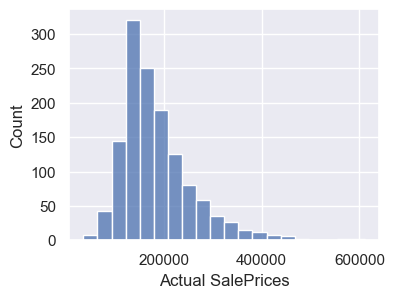

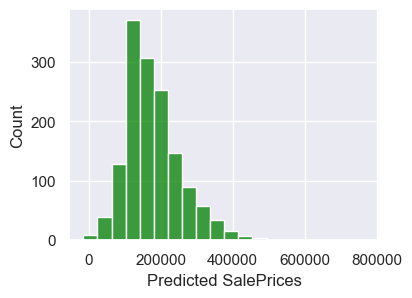

In [26]:
# generate predictions

# read in the data and validate format
final_test_df = pd.read_csv(r'house-prices-advanced-regression-techniques/test.csv')
print(final_test_df.head())
print('11111')
print(len(final_test_df))

# transform the data
trans_test_df = initial_clean(final_test_df)
trans_test_df = create_exists_feat(trans_test_df)
# trans_test_df = handle_missing_values(trans_test_df)
trans_test_df = map_qual_to_ord(trans_test_df)
trans_test_df = str_to_cat(trans_test_df)

# replace null values with mode or mean
print('\nMissing Values:')
num_nulls = trans_test_df[best_feat_cols].isnull().sum()
null_cols = num_nulls[num_nulls > 0]
for col in null_cols.index:
    print('\n')
    print(trans_test_df[col].value_counts())
    
mode_cols = ['NumBath', 'KitchenQual', 'BsmtQual', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'BsmtFinType1']
mean_cols = ['TotalBsmtSF', 'MasVnrArea', 'BsmtFinSF1', 'LotFrontage']
for col in mode_cols:
    trans_test_df[col].fillna(trans_test_df[col].mode()[0], inplace=True)
for col in mean_cols:
    trans_test_df[col].fillna(trans_test_df[col].mean(), inplace=True)

# create the model and train it on all data 
lr = LinearRegression()
lr.fit(feat_df[best_feat_cols], feat_df['SalePrice'])
test_predictions = lr.predict(trans_test_df[best_feat_cols])

test_pred_df = pd.DataFrame({'Id': trans_test_df['Id'], 'SalePrice': test_predictions})
print(test_pred_df)
print(len(test_pred_df))

# plot predictions
sns.set(rc = {'figure.figsize':(4,3)})
sns.histplot(data=feat_df, x='SalePrice', bins=20)
plt.xlabel('Actual SalePrices')
plt.show()

sns.histplot(data=test_pred_df, x='SalePrice', bins=20, color='green')
plt.xlabel('Predicted SalePrices')
plt.show()



In [28]:
# export

test_pred_df.to_csv('test_pred_df.csv', index=False)